# Credit Card Fraud Analysis

# Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import entropy

# MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer

# Functions

In [31]:
from sklearn.metrics import fbeta_score


def spot_check_models(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
    """
    This a quick way to spot check relevant algorithms to gain an understanding of 
    the dataset and which models handle the distribution well.

    Args:
        X_train_scaled (_type_): _description_
        X_test_scaled (_type_): _description_
        y_train_encoded (_type_): _description_
        y_test_encoded (_type_): _description_

    Returns:
        _type_: Sorted dataframe on accuracy scores.
    """
    models = {
        
        "GaussianNB": GaussianNB(),
        "LDA":LinearDiscriminantAnalysis(),
        "GPC":GaussianProcessClassifier(),
        
        "LogisticRegression": LogisticRegression(),
        "SVC": SVC(),
        "KNeighborsClassifier": KNeighborsClassifier(),
        
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
        "XGB":XGBClassifier()
    }

    # Create an empty DataFrame to store model performance
    model_performance = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        predictions = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, predictions)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy
        })

    # For the Sequential model
    sequential_model = Sequential()
    sequential_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    sequential_model.add(Dense(32, activation='relu'))
    sequential_model.add(Dense(1, activation='sigmoid'))
    sequential_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    sequential_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=10, verbose=0)
    loss, accuracy = sequential_model.evaluate(X_test_scaled, y_test_encoded)
    model_performance.append({
        "Model": "Sequential",
        "Accuracy": accuracy
    })

    # Convert the model_performance to a DataFrame
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Accuracy", ascending=False)


def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in names]

def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

def evaluate_model(X, y, model, metric):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  
  make_scorer(f2_measure)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def labels_to_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return probabilities

def calculate_entropy(df:pd.DataFrame)-> pd.DataFrame:
  """_summary_

  Args:
      df (pd.DataFrame): Pandas DataFrame

  Returns:
      pd.DataFrame: THe Entropy level of all models
  """

  column_entropy_info = {}
  for col in df.columns:
    probabilities = labels_to_probabilities(df[col])
    entropy_value = entropy(probabilities, base=2)
    column_entropy_info[col] = {
          'entropy': entropy_value
      }

  return pd.DataFrame(column_entropy_info)

# EDA Analysis

# Read in a subset of the data and try to match the class imbalance in the original dataset.

In [11]:
import pandas as pd
import numpy as np

total_samples = 10000
ratio = 258  


positives_needed = total_samples // (ratio + 1)
negatives_needed = total_samples - positives_needed


positives_count = 0
negatives_count = 0


sampled_data = []


chunk_size = 10000

# Randomly sample from each chunk
for chunk in pd.read_csv('data.csv', chunksize=chunk_size):
    # Separate positive and negative cases
    positives = chunk[chunk['is_fraud'] == 1]
    negatives = chunk[chunk['is_fraud'] == 0]

    positives_sample = positives.sample(min(len(positives), positives_needed - positives_count))
    negatives_sample = negatives.sample(min(len(negatives), negatives_needed - negatives_count))

    positives_count += len(positives_sample)
    negatives_count += len(negatives_sample)

    sampled_data.append(positives_sample)
    sampled_data.append(negatives_sample)

    # Break if we have enough samples
    if positives_count >= positives_needed and negatives_count >= negatives_needed:
        break

# Concatenate all sampled data into a single DataFrame
final_sample = pd.concat(sampled_data, ignore_index=True)

# Shuffle the final sample to mix positive and negative cases
df = final_sample.sample(frac=1).reset_index(drop=True)

In [5]:
df.isna().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
target = df.values[:,-1]

counter = Counter(target)

for k, v in counter.items():
  per = v/len(target) * 100
  print("Class=%d, Count=%d, Percentage=%.3f%%" % (k,v,per))

Class=0, Count=9962, Percentage=99.620%
Class=1, Count=38, Percentage=0.380%


# Important lesson for ML engineers, the class balance is 258:1 for the original dataset, in our sample it is 262:1. This means For every 258 examples of the majoirty class, there is only one from the minority class. Posting a 99% accuracy score shows a misunderstanding of the problem at hand. Because there are so few fraud examples, the model will not be able to predict the minority class which is costly to the business.

## Business Problem:

### Fraud cases are costly to banks, false negatives will be far more costly to their bottome line than false positives.

* Accuracy and F1 score's are irrelevant in this instance
* F1 score's and accuracy scores do not penalize false negatives
* F2 score's are what should be measured since they give greater weight to false positives.

In [8]:
df.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                   float64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

# Feature Engineering

In [13]:
df.drop(["Unnamed: 0", "street"], inplace=True, axis=1)

In [12]:
df["gender"] = df["gender"].apply(lambda x: 0 if x == "F" else 1)
df["trans_date_trans_time"] = pd.to_datetime(df['trans_date_trans_time'], format='%d/%m/%Y %H:%M', errors='coerce')
df["dob"] = pd.to_datetime(df['dob'], format='%d/%m/%Y', errors='coerce')

In [14]:
continuous_features = df.select_dtypes(include=["float64","int64"])
categorical_features = df.select_dtypes(include="object")

In [15]:
from collections import defaultdict

def convert_categorical_to_numerical(column_values:list):
  """
  Takes categorical columns and returns them into one hot encoding columns
  without exploding the amount of columns

  Args:
      column_values (list): tuple list of index, value

  Returns:
      Dictionary Key valued pair
  """
  converted_dict = defaultdict(list)
  
  for k, v in column_values:
    converted_dict[k] = v
  return converted_dict

binary_columns, mapping_dict = [], {}
for col in categorical_features.columns:
  unique_columns_values = categorical_features[col].unique()
  print(f" Col: {col}, Unique list: {len(unique_columns_values)}")
  if len(unique_columns_values) ==2:
    binary_columns.append(col)
  else:
    dict_values = [(value, idx )for (idx, value) in enumerate(sorted(unique_columns_values))]
    mapping_dict[col] = convert_categorical_to_numerical(dict_values)

 Col: merchant, Unique list: ['fraud_Medhurst, Cartwright and Ebert' 'fraud_Hoppe, Harris and Bednar'
 'fraud_Dickinson Ltd' 'fraud_Predovic Inc'
 'fraud_Turcotte, McKenzie and Koss' 'fraud_Dickinson-Rempel'
 'fraud_Larson-Moen' 'fraud_Morar Inc' 'fraud_Hills-Olson'
 'fraud_Price Inc' 'fraud_Bernier and Sons' 'fraud_Cole PLC'
 'fraud_Runolfsdottir, Mueller and Hand' 'fraud_Cormier LLC'
 'fraud_Abbott-Rogahn' 'fraud_Bednar PLC' 'fraud_Torp-Labadie'
 "fraud_O'Connell-Ullrich" 'fraud_Auer LLC' 'fraud_Conroy Ltd'
 'fraud_Kris-Padberg' 'fraud_Moore, Dibbert and Koepp'
 'fraud_Hoppe-Parisian' 'fraud_Terry, Johns and Bins'
 'fraud_Erdman-Durgan' 'fraud_Douglas-White' 'fraud_Friesen Ltd'
 'fraud_Larson, Quitzon and Spencer' 'fraud_Dibbert and Sons'
 'fraud_Leannon-Ward' 'fraud_Greenholt Ltd'
 'fraud_Lowe, Dietrich and Erdman' 'fraud_Renner Ltd'
 'fraud_Quitzon, Green and Bashirian' 'fraud_Boyer PLC'
 'fraud_Johnston-Casper' 'fraud_Christiansen, Goyette and Schamberger'
 'fraud_Kihn Inc' 'fraud

In [16]:
# Create copy of Dataframe for feature manipulation
replicate_df = df.copy()
replicate_df

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,city,state,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,length_cc_num
0,2020-06-22 21:53:00,4.957920e+12,"fraud_Medhurst, Cartwright and Ebert",personal_care,44.02,Alan,Parsons,1,Kirk,CO,...,-102.4776,207,Network engineer,1955-12-04,da35af431bbb7361d9fce6821613b043,1371937998,40.300795,-102.959635,0,15
1,2020-06-22 00:31:00,3.502380e+15,"fraud_Hoppe, Harris and Bednar",entertainment,38.69,Kathleen,Martin,0,New Waverly,TX,...,-95.4532,4993,"Scientist, biomedical",1948-11-30,9260e33726ee00fca30495c8c010ee1e,1371861092,30.570345,-95.502377,0,18
2,2020-06-22 22:02:00,3.566090e+15,fraud_Dickinson Ltd,personal_care,81.35,Kristina,Stewart,0,Newhall,CA,...,-118.5230,34882,Health physicist,1971-04-25,9212aafbfebead9afc76eed0fcc141bd,1371938527,33.991212,-119.048850,0,18
3,2020-06-21 22:35:00,4.560000e+18,fraud_Predovic Inc,shopping_net,15.56,Stacy,Villegas,0,Colorado Springs,CO,...,-104.6556,525713,Museum/gallery exhibitions officer,1992-05-09,b6c66e688e393a7f8add92d47387b50d,1371854149,39.011823,-103.907656,0,8
4,2020-06-22 14:00:00,3.573030e+15,"fraud_Turcotte, McKenzie and Koss",entertainment,3.48,Joanne,Williams,0,Altonah,UT,...,-110.4360,302,"Sales professional, IT",1990-01-17,c0af9a8d0c115619a4db6c03104f2c5d,1371909631,40.490800,-110.845896,0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2020-06-21 20:03:00,3.023530e+13,fraud_Mohr Inc,shopping_pos,2.25,Kenneth,Doyle,1,West Harrison,NY,...,-73.7395,11250,Lexicographer,1977-08-16,5505a9629be6d069b6a49136a4c45785,1371845034,40.059685,-74.397447,0,16
9996,2020-06-23 04:23:00,6.011950e+15,"fraud_Stanton, Jakubowski and Baumbach",shopping_net,269.25,Mckenzie,Brooks,0,Paris,MS,...,-89.3820,297,"Administrator, local government",1961-12-14,63b9112fc3cd0e785cf74ae9d429bc8f,1371961420,35.088122,-88.697688,0,18
9997,2020-06-22 17:40:00,3.691360e+13,fraud_O'Keefe-Wisoky,food_dining,44.28,Ana,Mccormick,0,Meridian,ID,...,-116.4306,84106,Intelligence analyst,1971-02-11,a6627d0fe50aa9578660b042e34f56da,1371922807,43.568471,-117.269092,0,16
9998,2020-06-22 20:20:00,3.575540e+15,fraud_Pacocha-Weissnat,kids_pets,42.84,Rachel,Villarreal,0,University,MS,...,-89.5736,4198,Curator,2001-06-22,84328d12a00e64e4b8bd78f74117b4d7,1371932430,34.835194,-89.746468,0,18


In [17]:
for k, v in mapping_dict.items():
  replicate_df[k] = replicate_df[k].apply(lambda x: v[x])

In [18]:
replicate_df

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,city,state,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,length_cc_num
0,2020-06-22 21:53:00,4.957920e+12,422,10,44.02,3,321,1,386,5,...,-102.4776,207,295,1955-12-04,8591,1371937998,40.300795,-102.959635,0,15
1,2020-06-22 00:31:00,3.502380e+15,263,0,38.69,184,255,0,524,42,...,-95.4532,4993,393,1948-11-30,5772,1371861092,30.570345,-95.502377,0,18
2,2020-06-22 22:02:00,3.566090e+15,136,10,81.35,197,399,0,528,4,...,-118.5230,34882,208,1971-04-25,5761,1371938527,33.991212,-119.048850,0,18
3,2020-06-21 22:35:00,4.560000e+18,486,11,15.56,294,424,0,154,5,...,-104.6556,525713,289,1992-05-09,7199,1371854149,39.011823,-103.907656,0,8
4,2020-06-22 14:00:00,3.573030e+15,637,0,3.48,161,450,0,16,43,...,-110.4360,302,389,1990-01-17,7596,1371909631,40.490800,-110.845896,0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2020-06-21 20:03:00,3.023530e+13,429,12,2.25,192,107,1,798,33,...,-73.7395,11250,255,1977-08-16,3289,1371845034,40.059685,-74.397447,0,16
9996,2020-06-23 04:23:00,6.011950e+15,594,11,269.25,225,43,0,579,24,...,-89.3820,297,9,1961-12-14,3854,1371961420,35.088122,-88.697688,0,18
9997,2020-06-22 17:40:00,3.691360e+13,460,1,44.28,13,268,0,468,12,...,-116.4306,84106,238,1971-02-11,6566,1371922807,43.568471,-117.269092,0,16
9998,2020-06-22 20:20:00,3.575540e+15,469,7,42.84,258,423,0,765,24,...,-89.5736,4198,107,2001-06-22,5208,1371932430,34.835194,-89.746468,0,18


# Visuals

<Axes: >

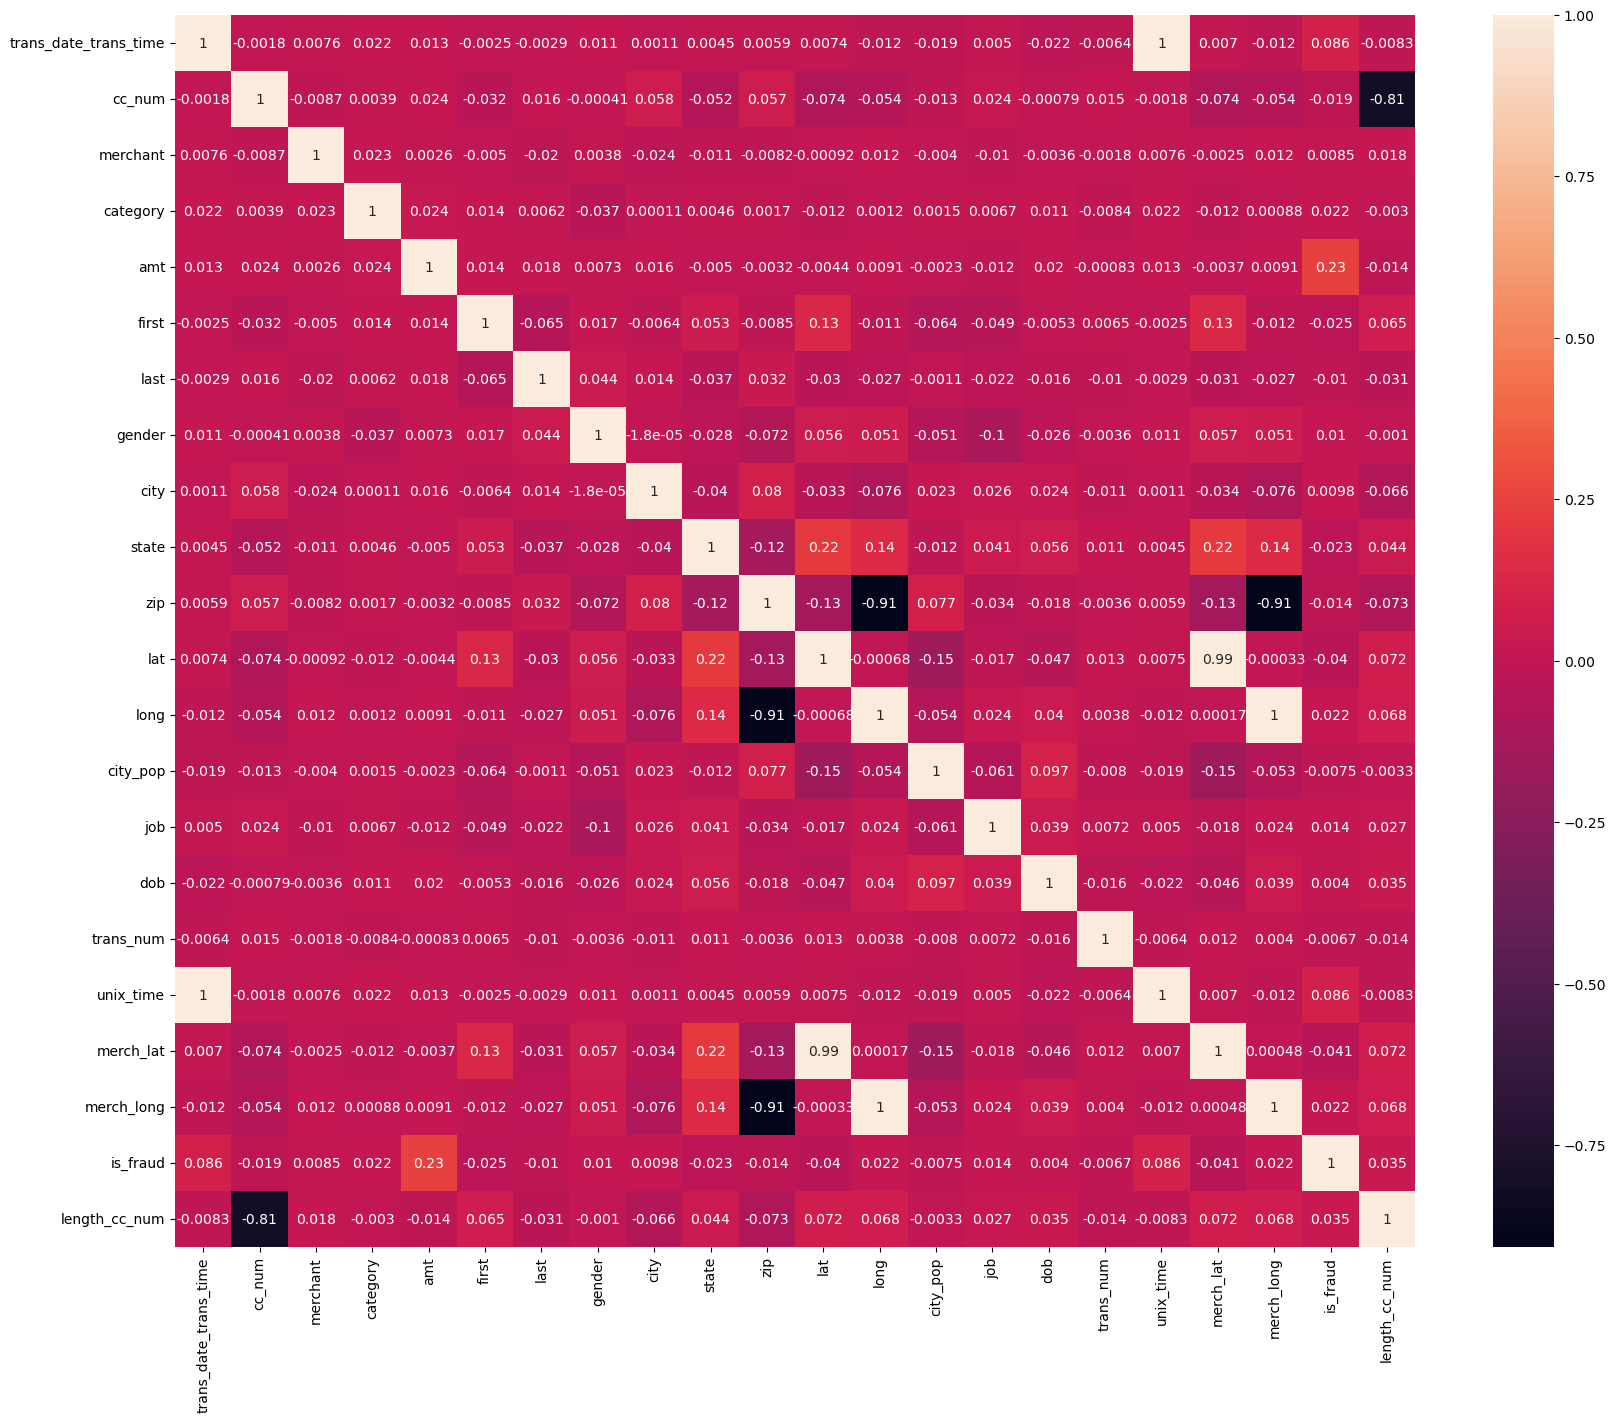

In [27]:
relations = replicate_df.corr()
plt.figure(figsize=(20,16))
sns.heatmap(data=relations, annot=True)

# Separate Feature and Target variables

In [ ]:
X, y = replicate_df.drop("is_fraud", axis=1), replicate_df["is_fraud"]

# Baseline Model Evaluation

In [ ]:
model = DummyClassifier(strategy='constant', constant=1)
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean F2: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

# Feature Importance

In [ ]:
# fit model on training data
from xgboost import plot_importance
model = XGBClassifier()
model.fit(X, y)
# plot feature importance
plot_importance(model)
plt.show()